Total ACH Deposit: $39000.00
Total Cost: $40716.31
Total Market Value: $43464.36

Profit/Loss: $2748.05
Profit/Loss Percentage: 6.75%
Total Realized Gain: $1826.30


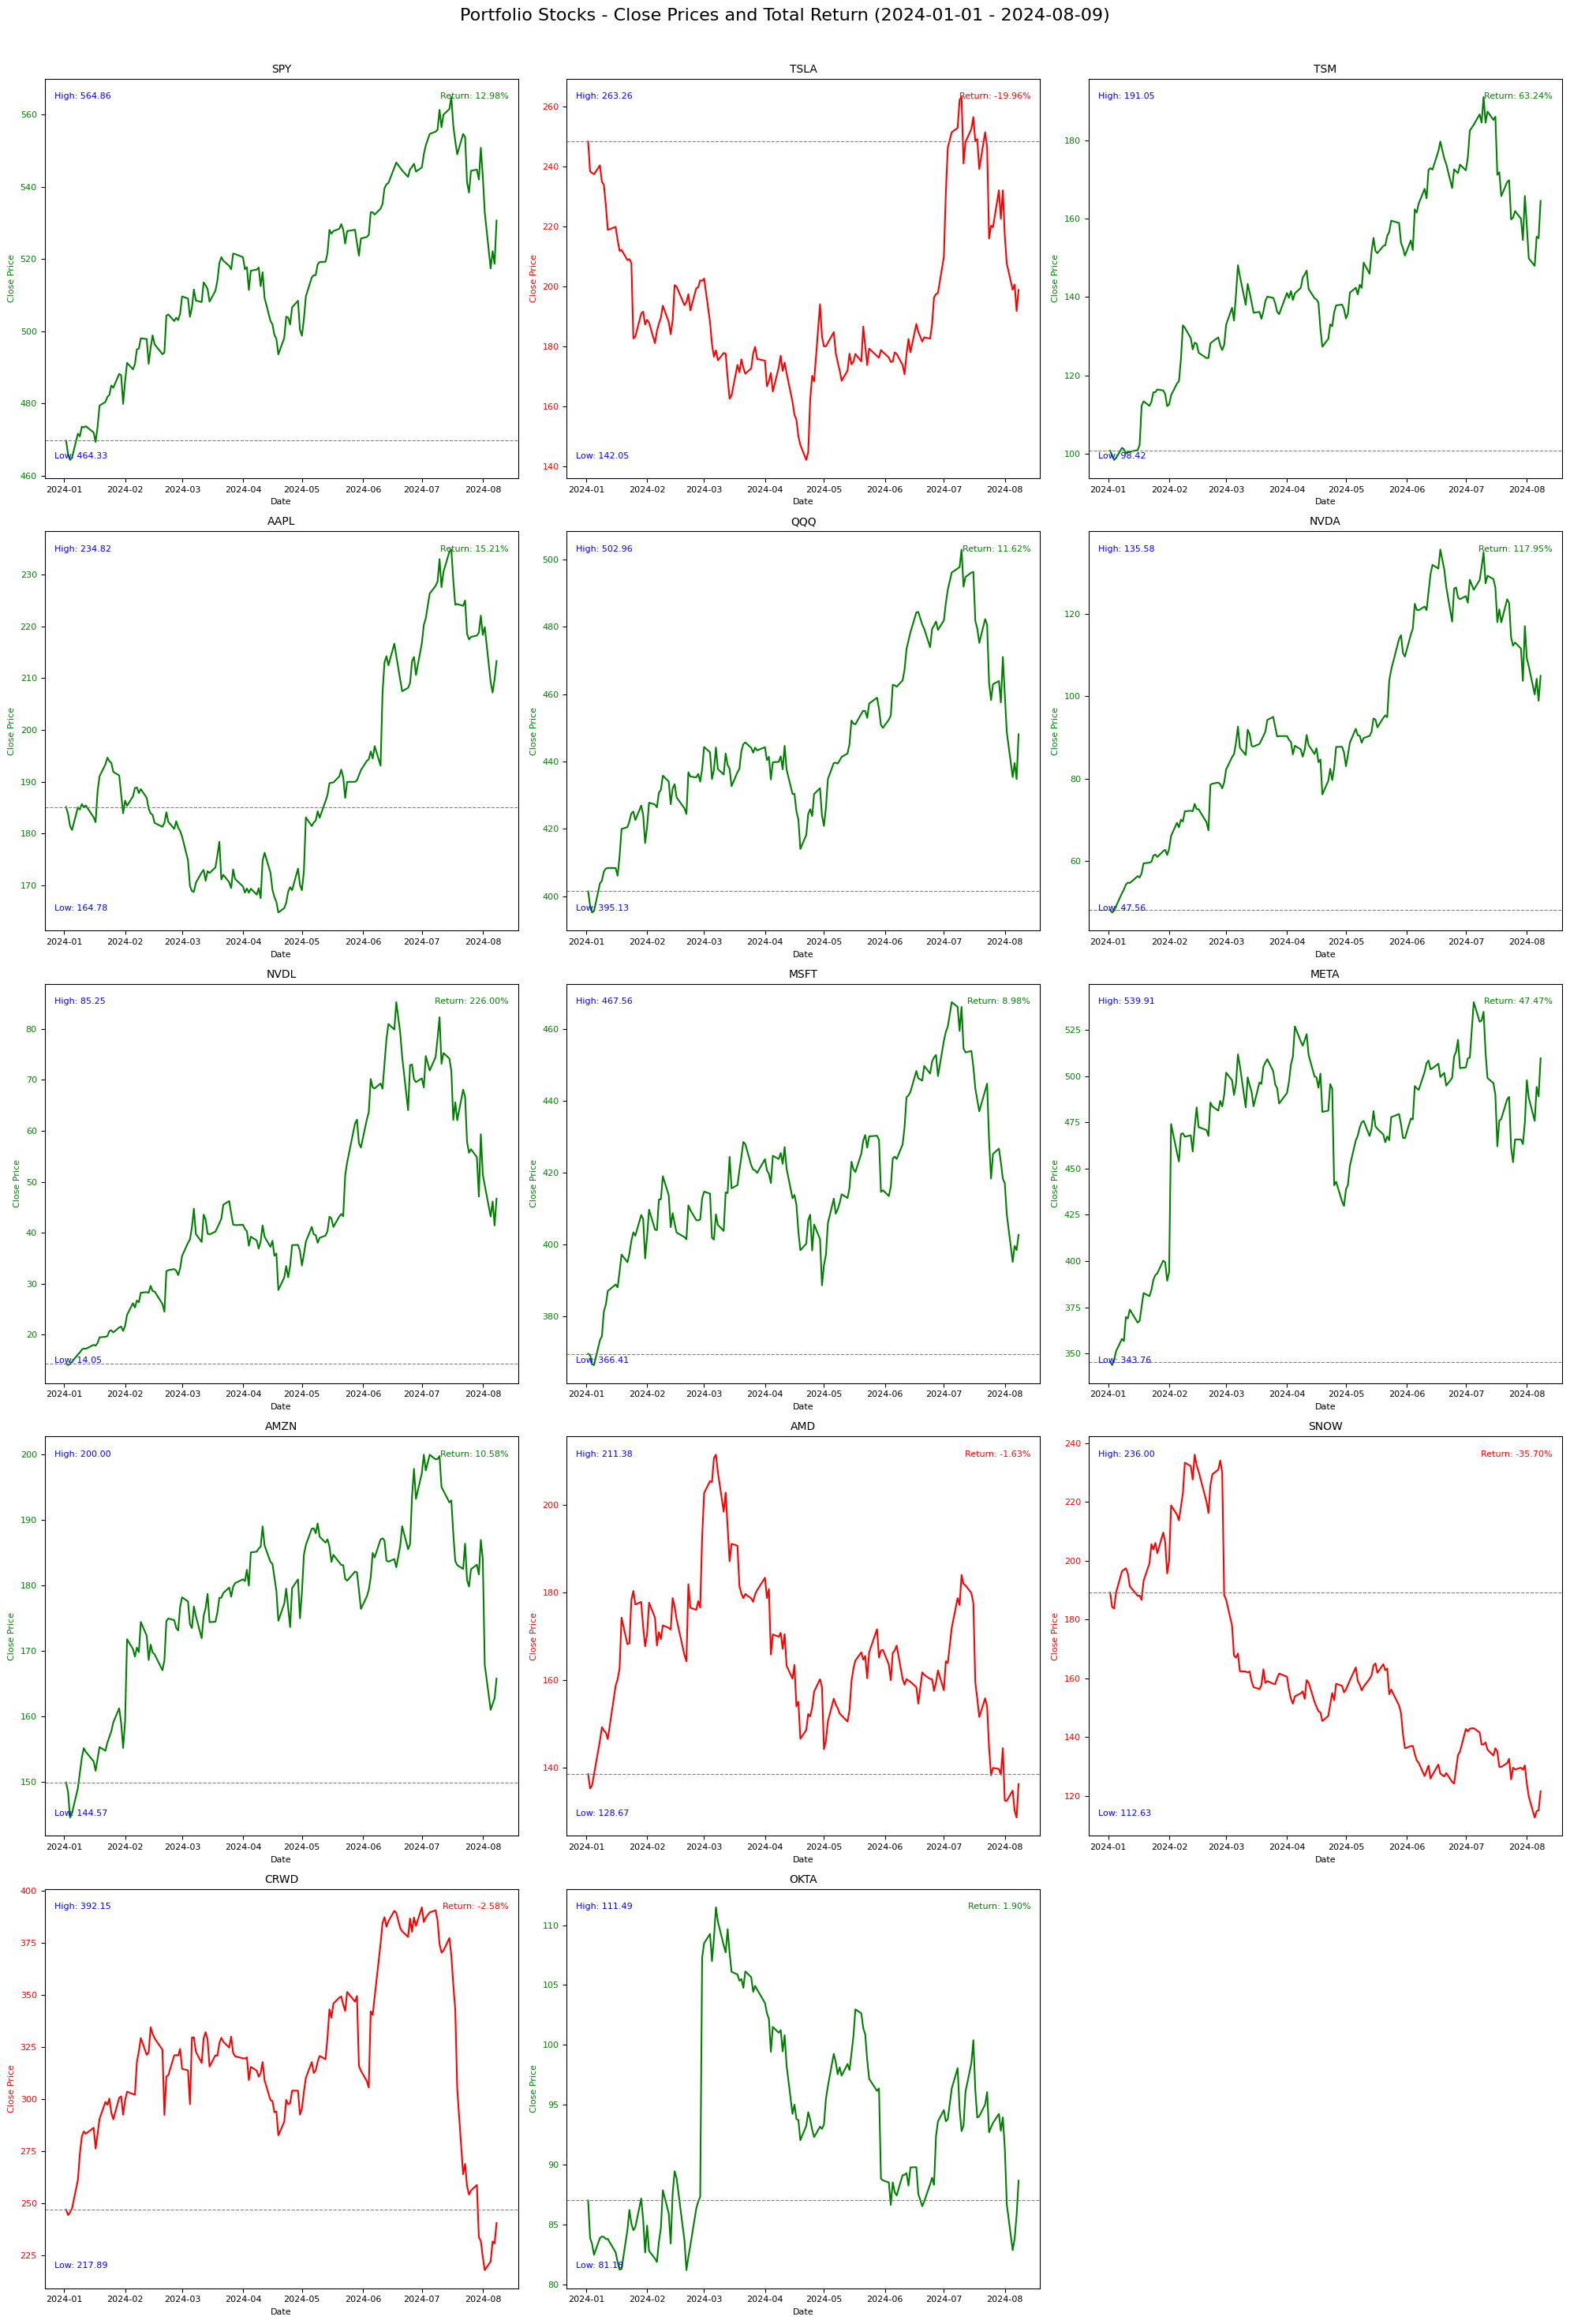

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
import numpy as np

# Read the CSV file
df = pd.read_csv('FT_CSV_87869971.csv')

def process_transactions(df):
    portfolio = {}
    open_positions = {}
    closed_positions = {}

    for _, row in df.iterrows():
        symbol = row['Symbol'].strip()
        action = row['Action']
        quantity = abs(float(row['Quantity']))
        price = float(row['Price']) if pd.notna(row['Price']) else 0.0

        if pd.notna(symbol) and action in ['BUY', 'SELL']:
            portfolio.setdefault(
                symbol, {'quantity': 0, 'latest_price': 0, 'market_value': 0})

            if action == 'BUY':
                portfolio[symbol]['quantity'] += quantity
                open_positions.setdefault(symbol, []).append(
                    {'quantity': quantity, 'price': price})
            elif action == 'SELL':
                portfolio[symbol]['quantity'] -= quantity
                process_sell(symbol, quantity, price, row['TradeDate'], open_positions, closed_positions)


            if portfolio[symbol]['quantity'] <= 0:
                del portfolio[symbol]

    return portfolio, open_positions, closed_positions


def process_sell(symbol, quantity, price, date, open_positions, closed_positions):
    while quantity > 0 and open_positions[symbol]:
        buy = open_positions[symbol][0]
        closed_quantity = min(buy['quantity'], quantity)
        quantity -= closed_quantity
        buy['quantity'] -= closed_quantity

        if buy['quantity'] == 0:
            open_positions[symbol].pop(0)

        closed_positions.setdefault(symbol, []).append({
            'buy_price': buy['price'],
            'sell_price': price,
            'quantity': closed_quantity,
            'sell_date': date
        })


def calculate_realized_gain(closed_positions):
    return sum((trade['sell_price'] - trade['buy_price']) * trade['quantity']
               for trades in closed_positions.values()
               for trade in trades)


# Use the new functions
portfolio, open_positions, closed_positions = process_transactions(df)
realized_gain = calculate_realized_gain(closed_positions)


def update_portfolio_data(portfolio, open_positions):
    total_cost = 0
    total_market_value = 0

    for symbol, data in portfolio.items():
        stock = yf.Ticker(symbol)
        latest_price = stock.history(period="1d")['Close'].iloc[-1]
        data['latest_price'] = latest_price
        data['market_value'] = data['quantity'] * latest_price
        total_market_value += data['market_value']

        position_cost = sum(trade['quantity'] * trade['price']
                            for trade in open_positions[symbol])
        total_cost += position_cost

    return total_cost, total_market_value


# Use the new function
total_ach_deposit = df[df['Description'].str.contains(
    'ACH DEPOSIT', na=False)]['Amount'].sum()
total_cost, total_market_value = update_portfolio_data(
    portfolio, open_positions)

profit_loss = total_market_value - total_cost
profit_loss_percentage = (profit_loss / total_cost) * \
    100 if total_cost != 0 else 0

# Print results
print(f"Total ACH Deposit: ${total_ach_deposit:.2f}")
print(f"Total Cost: ${total_cost:.2f}")
print(f"Total Market Value: ${total_market_value:.2f}")
print(f"\nProfit/Loss: ${profit_loss:.2f}")
print(f"Profit/Loss Percentage: {profit_loss_percentage:.2f}%")
print(f"Total Realized Gain: ${realized_gain:.2f}")


def plot_portfolio(portfolio, start_date=None, end_date=None, period=None, n_cols=3):
    # Get historical data
    for symbol in portfolio:
        stock = yf.Ticker(symbol)

        if start_date and end_date:
            stock_hist = stock.history(
                start=start_date, end=end_date, interval='1d')
        elif period:
            stock_hist = stock.history(period=period)
        else:
            stock_hist = stock.history(period="max")

        portfolio[symbol]['latest_price'] = stock_hist['Close'].iloc[-1]
        portfolio[symbol]['market_value'] = portfolio[symbol]['quantity'] * \
            portfolio[symbol]['latest_price']
        portfolio[symbol]['history'] = stock_hist['Close']

    # Calculate number of rows and columns for subplots
    n_symbols = len(portfolio)
    n_rows = (n_symbols - 1) // n_cols + 1

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    fig.suptitle(
        f'Portfolio Stocks - Close Prices and Total Return ({start_date} - {end_date})', fontsize=16)

    for idx, (symbol, ax) in enumerate(zip(portfolio, axes.flatten())):
        history = portfolio[symbol]['history']

        # Calculate total return
        total_return = (history.iloc[-1] / history.iloc[0] - 1) * 100
        color = 'g' if total_return >= 0 else 'r'

        # Plot closing price
        ax.plot(history.index, history, color=color)
        ax.set_xlabel('Date', fontsize=8)
        ax.set_ylabel('Close Price', color=color, fontsize=8)
        ax.tick_params(axis='y', labelcolor=color, labelsize=8)
        ax.tick_params(axis='x', labelsize=8)

        # Set title and show information
        ax.set_title(f'{symbol}', fontsize=10)

        # Add min, max, and return annotations
        min_close = history.min()
        max_close = history.max()

        ax.annotate(f'Low: {min_close:.2f}', xy=(0.02, 0.05),
                    xycoords='axes fraction', fontsize=8, color='b')
        ax.annotate(f'High: {max_close:.2f}', xy=(0.02, 0.95),
                    xycoords='axes fraction', fontsize=8, color='b')
        ax.annotate(f'Return: {total_return:.2f}%', xy=(
            0.98, 0.95), xycoords='axes fraction', fontsize=8, color=color, ha='right')

        # Add horizontal line for starting price
        start_price = history.iloc[0]
        ax.axhline(y=start_price, color='gray', linestyle='--', linewidth=0.8)

    # Remove any unused subplots
    for idx in range(n_symbols, n_rows * n_cols):
        fig.delaxes(axes.flatten()[idx])

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust to make room for suptitle
    plt.show()


# Get the trade date of the first row
# start_date = df['TradeDate'].iloc[0] // first trade date
start_date = datetime(datetime.now().year, 1, 1).strftime('%Y-%m-%d')

# Get tomorrow's date to ensure today is included
end_date = (datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')

# Plot the portfolio
plot_portfolio(portfolio, start_date=start_date, end_date=end_date)